In [1]:
import autograd.numpy as np
from autograd import grad

import pandas as pd
import numpy
from numpy.linalg import norm
import random

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
def load_data(path='lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'):
    raw_data = pd.read_table('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')
    raw_data = raw_data.drop(raw_data.columns[1], axis=1)
    raw_data.columns = ['user', 'artist', 'plays']
    data = raw_data.dropna().sample(frac=1)#[:70]
    data = data.loc[data.plays != 0]
    return data

def crop_data(data, mask):
    data = data[mask]
    data['user_id'] = data['user'].astype("category").cat.codes
    data['artist_id'] = data['artist'].astype("category").cat.codes
    data = data.drop(['user', 'artist'], axis=1)

    users = list(np.sort(data.user_id.unique()))
    artists = list(np.sort(data.artist_id.unique()))
    plays = list(data.plays)

    rows = data.user_id.astype(int)
    cols = data.artist_id.astype(int)

    return sparse.csr_matrix((plays, (rows, cols)), shape=(len(users), len(artists)))

In [3]:
data = load_data(path='lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')

In [4]:
mask = np.full(len(data), False)
mask[:70] = True
np.random.shuffle(mask)
data_sparse = crop_data(data, mask)

while True:
    mask = np.full(len(data), False)
    mask[:70] = True
    np.random.shuffle(mask)
    data_sparse = crop_data(data, mask)
    if data_sparse.shape == (70, 70):
        break
    


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [5]:
data_sparse

<70x70 sparse matrix of type '<class 'numpy.int64'>'
	with 70 stored elements in Compressed Sparse Row format>

In [6]:
factors = 40
lambda_ = 0.1
L = 10

In [7]:
def f(x, A, num_users, factors, lambda_):
    u = x[:num_users*factors].reshape((-1, factors))
    v = x[num_users*factors:].reshape((-1, factors))
    
    p = A.copy()
    p[np.where(p != 0)] = 1.0
    return np.sum(np.multiply(A + 1, (p - np.dot(u, v.T)) ** 2)) + lambda_ * (np.linalg.norm(u)**2 + np.linalg.norm(v)**2)


def alt_least_squares_iter(A, first, size, fixed_vecs, factors, lambda_):
    num_fixed = fixed_vecs.shape[0]
    YTY = fixed_vecs.T.dot(fixed_vecs)
    eye = np.eye(num_fixed)
    lambda_eye = lambda_ * np.eye(factors)
    solve_vecs = np.zeros((size, factors))

    for i in range(size):
        if first:
            counts_i = A[i]
        else:
            counts_i = A[:, i].T
        CuI = np.eye(counts_i.shape[0])
        np.fill_diagonal(CuI, counts_i)
        
        pu = counts_i.copy()
        pu[np.where(pu != 0)] = 1.0
        YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
        YTCupu = fixed_vecs.T.dot(CuI + eye).dot(pu.T)
        xu = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)
        solve_vecs[i] = xu

    return solve_vecs

In [8]:
w0 = np.random.random(size=(data_sparse.shape[0] + data_sparse.shape[1]) * factors) * 0.1
f_loss = lambda x: f(x, data_sparse.toarray(), data_sparse.shape[0], factors, lambda_=lambda_)

In [9]:
def acc_alt_least_squares(x_start, A, factors, maxtime=60, lambda_=5):
    num_users = A.shape[0]
    num_items = A.shape[1]
        
    f_loss = lambda x: f(x, A, num_users, factors, lambda_)
    
    def f_loss_1d(x, e):
        def f1d(h):
            return f_loss(x + h * e)
        return f1d

        
    user_vectors = x_start[:num_users*factors].reshape((-1, factors))
    item_vectors = x_start[num_users*factors:].reshape((-1, factors))
    
    history = []
    history_f = []
    history_time = []
    
    history.append(x_start)
    history_f.append(f_loss(x_start))
    history_time.append(0.)

    AA=0
    L=0.5
    y = x_start.copy()
    z = x_start.copy()
    y_t = x_start.copy()
        
    start_time = time.perf_counter()
    k=0
    while True:
        flag = 1; #flag of the end of the inner cycle
        j = 0; #corresponds to j_k
        while flag > 0:
            L_t = 2**(j-1)*L; #current trial for L
            a_t = (1  + np.sqrt(1 + 4 * L_t * AA) )/ 2 / L_t ; # trial of a_k
            A_t = AA + a_t; #trial of A_k
            tau = a_t / A_t; #trial of \tau_{k}
            x_t = tau * z + (1 - tau) * y; #trial for x_k
            grad_f_x_t = grad(f_loss)(x_t)
            
            f_x_t = f_loss(x_t)
            
            grad_norm_square = (grad_f_x_t*grad_f_x_t).sum()
            
            user_vectors = x_t[:num_users*factors].reshape((-1, factors))
            item_vectors = x_t[num_users*factors:].reshape((-1, factors))
            if k%2 == 0:
                user_vectors = alt_least_squares_iter(A, True, num_users, item_vectors, factors, lambda_)
            else:
                item_vectors = alt_least_squares_iter(A, False, num_items, user_vectors, factors, lambda_)

            point = np.concatenate([user_vectors.reshape(-1), item_vectors.reshape(-1)])
            y_t = point
            
            z_t = z - a_t * grad_f_x_t; #trial of z_k 
            f_y_t = f_loss(y_t)
            
            l = grad_norm_square/(2*L_t)-(f_x_t-f_y_t)
            if l <= 0: #if the stopping criterion is fulfilled
                flag = 0 #end of the inner cycle flag
                #x = x_t; #set x_{k+1}
                y = y_t.copy() #set y_{k+1}
                z = z_t.copy() #set y_{k+1}
                AA = A_t.copy() #set A_{k+1}
                L = L_t #set L_{k+1}
            j = j + 1;
        
        if k%2==0:
            history.append(point)
            history_f.append(f_loss(point))
            history_time.append(time.perf_counter() - start_time)
        
        if k % 200 == 0:
            print("   ", history_f[-1])
        k-=-1
        if(history_time[-1]>maxtime):
            return history, history_f, history_time
        
            
    return history, history_f, history_time

In [10]:

def AGMsDR(x_start, args, maxtime=60):
    history = []
    history_f = []
    history_time = []
    
    history.append(x_start)
    history_f.append(f_loss(x_start))
    history_time.append(0.)


    mu=0 #ONLY!
    A = 0.
    tau = 1.
    x, v = x_start.copy(), x_start.copy()
    
    start_time = time.perf_counter()
    f_x = None
    t=np.ones(2, np.float64)
    i=0
    while True:
        y, f_y, grad_f_y, norm2_grad_f_y, x, f_x, t[i%2] = agmsdr_iter(i, t[i%2], f_x, x, v, args)
        #print('\n')
        g = (f_x - f_y)
        a = norm2_grad_f_y + 2*mu*g
        b = 2*mu*A*g + 2*tau*g - mu*tau*(((v - y)*(v - y)).sum())
        c = 2*A*tau*g

        alpha = (-b + np.sqrt(b*b - 4*a*c)) / 2 / a
        
        
        A = A + alpha
        
        v = tau*v + mu*alpha*y - alpha * (grad_f_y)
        tau = tau+mu*alpha
        v/=tau
        
        
        if i%2==0:
            history_time.append(time.perf_counter() - start_time)
            history_f.append(f_x)
        if i % 200 == 0:
            print("   ", history_f[-1])
        i-=-1
        if(history_time[-1]>maxtime):
            return 0, history_f, history_time
        i-=-1
            
    return np.array(history_f), np.array(history_time)

def agmsdr_iter(i, t, f_x, x, v, args):
    A, factors, lambda_ = args
    def check(t, args, forcereturn=False):
        A, factors, lambda_ = args
        num_users = A.shape[0]
        num_items = A.shape[1]  
        #print(i,': ', t)
        y = v + t * (x-v)
        f_y = f_loss(y)
        grad_f_y = grad(f_loss)(y)
        if (grad_f_y.dot(v-y) >= 0 and f_x >= f_y) or forcereturn:
            gu, gv = (grad_f_y[:num_users*factors]**2).sum(), (grad_f_y[num_users*factors:]**2).sum()
            norm2_grad_f_y = (gu+gv)

            x_new = y.copy()    
            user_vectors = y[:num_users*factors].reshape((-1, factors))
            item_vectors = y[num_users*factors:].reshape((-1, factors))
            if gu > gv:    
                user_vectors = alt_least_squares_iter(A, True, num_users, item_vectors, factors, lambda_)
            else:
                item_vectors = alt_least_squares_iter(A, False, num_items, user_vectors, factors, lambda_)

            point = np.concatenate([user_vectors.reshape(-1), item_vectors.reshape(-1)])
            ##########################################################
            x_new = point
            f_x_new=f_loss(x_new)
            return True, (y, f_y, grad_f_y , norm2_grad_f_y, x_new, f_x_new, t) #f(x_new) can be optimized
        else:
            return False, grad_f_y

    if f_x==None: f_x = f_loss(x) 
    tl=None
    tr=np.float128(t)
    k=0
    while True: #find right endpoint for line search
        is_ok, ret = check(tr, args)
        if is_ok:
            return ret
        else:
            gr = ret
        if gr.dot(x-v) < 0:
            tl=tr
            tr= 1 + 1e-8 * k**10
        else:
            break
        k-=-1
    
    
    tmp=max(0, min(tr-(1 - (i+1)/(i+2)), (i+1)/(i+2))) #step left    
    k=1
    while tl==None:#find left endpoint for line search
        is_ok, ret = check(tmp, args)
        if is_ok:
            return ret
        else:
            gtmp = ret
        if gtmp.dot(x-v) <= 0:
            tl=tmp
            break
        else:
            tr=tmp
        tmp = 1 - (1-tmp**(4)) 

    while True:
        if tr < 0.8 or tl >= 1.:
            tc = tl + (tr-tl)*3/5
        else:
            tc = tl + (tr-tl)*4/5

        is_ok, ret = check(tc, args, tc==tr or tc==tl)

        if is_ok:
            return ret
        else:
            gc = ret
        if gc.dot(x-v) > 0:
            tr=tc
        else:
            tl=tc



In [11]:
def alt_least_squares(x_start, A, factors, maxtime=60, lambda_=5):
    num_users = A.shape[0]
    num_items = A.shape[1]
        
    f_loss = lambda x: f(x, A, num_users, factors, lambda_)
        
    user_vectors = x_start[:num_users*factors].reshape((-1, factors))
    item_vectors = x_start[num_users*factors:].reshape((-1, factors))
    
    history = []
    history_f = []
    history_time = []
    
    history.append(x_start)
    history_f.append(f_loss(x_start))
    history_time.append(0.)
    
    start_time = time.perf_counter()
    i=0
    while True:
        user_vectors = alt_least_squares_iter(A, True, num_users, item_vectors, factors, lambda_)
        item_vectors = alt_least_squares_iter(A, False, num_items, user_vectors, factors, lambda_)
        
        point = np.concatenate([user_vectors.reshape(-1), item_vectors.reshape(-1)])
        history.append(point)
        history_f.append(f_loss(point))
        history_time.append(time.perf_counter() - start_time)
        
        if i % 100 == 0:
            #x = user_vectors.dot(item_vectors.T)
            print("   ", history_f[-1])
        
        if(history_time[-1]>maxtime):
            return history, history_f, history_time
        i-=-1   
            
    return history, history_f, history_time


In [12]:
maxtime = 120

In [13]:
_, y_array, x_array = alt_least_squares(w0*10, data_sparse.toarray(), factors, maxtime=maxtime, lambda_=lambda_)

/usr/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


    78.7429156647932
    67.05421891368833
    66.24296365303046
    65.85149212662157
    65.62283978179502
    65.47202198905978
    65.36371348552339
    65.28115032863444
    65.21552102707872
    65.16177291539108


In [14]:
_, agm_y_array, agm_x_array = AGMsDR(w0*10, (data_sparse.toarray(), factors, lambda_), maxtime=maxtime)

    149.25708489020002
    73.56974772098373
    69.64199898754391
    68.27461344854865
    66.61016870353986
    65.95667596416179
    65.14044922693978
    64.7609590481305
    64.68198774434481
    64.66413219129652
    64.65563916913023
    64.65074563932527
    64.64744435805997
    64.6450838023824
    64.64325040687851
    64.64178467648327
    64.6406024000577
    64.63964770047323


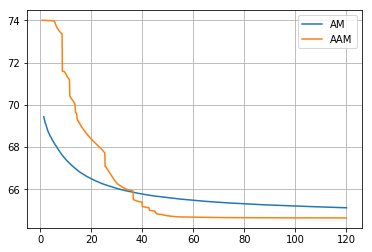

In [15]:
plt.plot(x_array[10:], y_array[10:], label='AM')
plt.plot(agm_x_array[10:], agm_y_array[10:], label='AAM')
plt.grid(True)
plt.legend()
plt.show()